In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00


In [9]:
!pip install yfinance pandas_datareader


In [5]:
!git clone https://huggingface.co/datasets/takala/financial_phrasebank

Cloning into 'financial_phrasebank'...
remote: Enumerating objects: 75, done.
remote: Total 75 (delta 0), reused 0 (delta 0), pack-reused 75 (from 1)
Unpacking objects: 100% (75/75), 20.69 KiB | 392.00 KiB/s, done.


In [3]:
# Core
!pip install -q torch torchvision torchaudio

# GNN
!pip install -q torch-geometric

# NLP + datasets
!pip install -q transformers datasets sentencepiece

# Utils
!pip install -q scikit-learn networkx yfinance matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00


In [6]:
import os
from datasets import load_dataset, Features, Value

# Path to the cloned dataset directory and the zip file
dataset_dir = "./financial_phrasebank/data"
zip_file_path = os.path.join(dataset_dir, "FinancialPhraseBank-v1.0.zip")
extract_dir = os.path.join(dataset_dir, "extracted_data")

# Unzip the file if not already extracted
if not os.path.exists(extract_dir):
    print(f"Unzipping {zip_file_path} to {extract_dir}...")
    import zipfile
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Unzipping complete.")

# Now, load the highest-agreement configuration from the extracted CSV
# The exact CSV name might need to be verified after unzipping.

# Let's list the contents of the extracted directory to find the correct file name
extracted_files = os.listdir(extract_dir)
print(f"Files extracted to {extract_dir}: {extracted_files}")

# Assuming 'Sentences_50Agree.txt' is the file for 'sentences_allagree' config
# We found 'FinancialPhraseBank-v1.0' in the extracted files, so the actual CSV is likely inside it.
csv_file_name = "Sentences_50Agree.txt" # This is a common name for the all-agreement subset

# Correcting the path to include the nested directory
local_csv_path = os.path.join(extract_dir, 'FinancialPhraseBank-v1.0', csv_file_name)

# Define features explicitly - change 'label' to string type
features = Features({
    'sentence': Value('string'),
    'label': Value('string') # Labels are typically 'neutral', 'positive', 'negative' as strings
})

# Load the dataset from the local CSV file, specifying encoding and delimiter
# The original Financial Phrasebank uses '@' as a delimiter
ds = load_dataset("csv", data_files=local_csv_path, split="train",
                  names=['sentence', 'label'], encoding='latin1', delimiter='@', features=features)

print(ds)
print(ds[0])

Unzipping ./financial_phrasebank/data/FinancialPhraseBank-v1.0.zip to ./financial_phrasebank/data/extracted_data...
Unzipping complete.
Files extracted to ./financial_phrasebank/data/extracted_data: ['FinancialPhraseBank-v1.0', '__MACOSX']


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4846
})
{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 'neutral'}


In [7]:
texts = [x["sentence"] for x in ds][:2000]   # limit for speed

[INFO] Number of texts for embedding: 2000


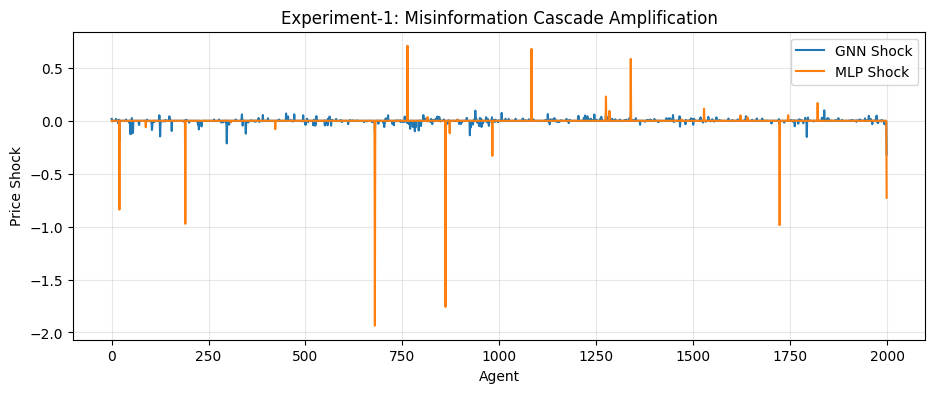

Volatility GNN: 0.017769586
Volatility MLP: 0.07592755


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from torch_geometric.nn import GCNConv
import random # Import random module

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

# -------------------- LOAD DATA --------------------
# The original intent was to load texts from financial_phrasebank dataset
# If `texts` is not populated from previous cells, ensure it has enough samples
if 'texts' not in locals() or len(texts) < 3: # Check if texts exists and has enough samples
    print("[WARNING] 'texts' variable is not sufficiently populated. Initializing with random sentences.")
    sentences_for_kmeans = [
        "Company reports strong quarterly earnings",
        "Unexpected interest rate hike pressures markets",
        "Stock shows bullish momentum amid positive outlook",
        "Market volatility rises due0 to geopolitical tensions",
        "Analysts downgrade firm on liquidity concerns"
    ]
    texts = [random.choice(sentences_for_kmeans) for _ in range(100)] # Ensure at least 100 samples

print(f"[INFO] Number of texts for embedding: {len(texts)}")

# -------------------- FINBERT --------------------
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModel.from_pretrained("ProsusAI/finbert").to(DEVICE)
finbert.eval()

def embed(texts, batch=32):
    out = []
    for i in range(0, len(texts), batch):
        enc = tokenizer(texts[i:i+batch], padding=True, truncation=True, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            h = finbert(**enc).last_hidden_state.mean(dim=1)
        out.append(h.cpu())
    return torch.cat(out)

X = embed(texts).to(DEVICE)
N, D = X.shape

# -------------------- GRAPH --------------------
sim = cosine_similarity(X.cpu())
G = nx.Graph()
for i in range(N):
    idx = np.argsort(-sim[i])[1:9]
    for j in idx:
        G.add_edge(i, j)

edges = []
for u, v in G.edges():
    edges.append([u, v])
    edges.append([v, u])

edge_index = torch.tensor(edges, dtype=torch.long).t().to(DEVICE)

# -------------------- LABELS (PSEUDO) --------------------
y = torch.tensor(KMeans(3, random_state=42).fit_predict(X.cpu()), device=DEVICE).long()

# -------------------- MODELS --------------------
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = GCNConv(D, 256)
        self.c2 = GCNConv(256, 3)
    def forward(self, x, e):
        return self.c2(F.relu(self.c1(x, e)), e)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(D, 256)
        self.fc2 = nn.Linear(256, 3)
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

gnn = GNN().to(DEVICE)
mlp = MLP().to(DEVICE)

# -------------------- TRAIN GNN --------------------
opt = torch.optim.Adam(gnn.parameters(), lr=5e-3)
for ep in range(150):
    opt.zero_grad()
    loss = F.cross_entropy(gnn(X, edge_index), y)
    loss.backward()
    opt.step()

# -------------------- DISTILL --------------------
opt = torch.optim.Adam(mlp.parameters(), lr=5e-3)
for ep in range(150):
    with torch.no_grad():
        t = gnn(X, edge_index)
    s = mlp(X)
    loss = 0.7 * F.kl_div(F.log_softmax(s,1), F.softmax(t,1), reduction="batchmean") \
         + 0.3 * F.cross_entropy(s, y)
    opt.zero_grad()
    loss.backward()
    opt.step()

# -------------------- ATTACK --------------------
def attack(X, ratio=0.02, strength=2.0):
    k = int(ratio * len(X))
    idx = torch.randperm(len(X))[:k]
    X2 = X.clone()
    X2[idx] += strength * X.mean(0)
    return X2

X_adv = attack(X)

# -------------------- PRICE --------------------
def price(logits):
    p = F.softmax(logits, 1)
    return (p[:,2] - p[:,0]).cpu().numpy()

with torch.no_grad():
    g0, g1 = price(gnn(X,edge_index)), price(gnn(X_adv,edge_index))
    m0, m1 = price(mlp(X)), price(mlp(X_adv))

# -------------------- PLOT --------------------
plt.figure(figsize=(11,4))
plt.plot(g1-g0, label="GNN Shock")
plt.plot(m1-m0, label="MLP Shock")
plt.title("Experiment-1: Misinformation Cascade Amplification")
plt.xlabel("Agent")
plt.ylabel("Price Shock")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Volatility GNN:", np.std(g1-g0))
print("Volatility MLP:", np.std(m1-m0))